<a href="https://colab.research.google.com/github/jplulu/Frequentist-ML/blob/master/linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [302]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

In [303]:
# -----------------Using prostate data from the book

# Read data
df = pd.read_csv('https://github.com/jplulu/Frequentist-ML/raw/master/datasets/prostate.csv', sep='\t', index_col=0)

In [304]:
# ----------------- Preprocess data

# Added ones column for intercept
ones_col = np.ones(len(df))
df.insert(0, "intercept", ones_col)
df = df.drop(['train'],axis=1)

# Select random seed for data splitting
np.random.seed(45)

# Separate training, validation, and testing data
df_train, df_val, df_test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

# Separate training inputs and outputs
x_train = df_train.drop(['lpsa'], axis=1)
y_train = df_train['lpsa']

# Separate validation inputs and outputs
x_val = df_val.drop(['lpsa'], axis=1)
y_val = df_val['lpsa']

# Separate testing inputs and outputs
x_test = df_test.drop(['lpsa'], axis=1)
y_test = df_test['lpsa']

# Standardizing predictors to zero mean unit variance
x_train = (x_train - x_train.mean()) / x_train.std()
x_train.intercept = np.ones(len(x_train))
x_val = (x_val - x_val.mean()) / x_val.std()
x_val.intercept = np.ones(len(x_val))
x_test = (x_test - x_test.mean()) / x_test.std()
x_test.intercept = np.ones(len(x_test))

In [305]:
# -----------------Linear Regression, No regularization

# Train the model and compute beta
def compute_beta_noreg(x_train, y_train):
  x_train_inv = np.linalg.inv(np.dot(x_train.transpose(), x_train))
  beta_noreg = np.dot(np.dot(x_train_inv, x_train.transpose()), y_train)
  return beta_noreg

beta_noreg = compute_beta_noreg(x_train, y_train)
# Compute MSE on the test dataset
mse_noreg = np.mean((y_test - np.dot(x_test, beta_noreg))**2)
print("Mean squared error on the test dataset: {}".format(mse_noreg))

Mean squared error on the test dataset: 0.6092222290063078


In [306]:
# -----------------Recreate Tables 3.1 and 3.2

# Compute and display correlation matrix
corr_matrix = df.drop(['intercept','lpsa'], axis=1).corr()
display(corr_matrix)

# Compute and display linear model fit table
x_inv_diag = np.diagonal(np.linalg.inv(np.dot(x_train.transpose(), x_train)))
# Equation (3.12)
std_err = np.dot(beta_noreg.std(), np.sqrt(x_inv_diag))
z_score = beta_noreg / std_err
zipped_list =  list(zip(list(x_train.columns), beta_noreg, std_err, z_score))
model_fit_table = pd.DataFrame(zipped_list, columns = ['Term' , 'Coefficient', 'Std. Error', 'Z Score'])
display(model_fit_table)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.280521,0.225000,0.027350,0.538845,0.675310,0.432417,0.433652
lweight,0.280521,1.000000,0.347969,0.442264,0.155385,0.164537,0.056882,0.107354
age,0.225000,0.347969,1.000000,0.350186,0.117658,0.127668,0.268892,0.276112
lbph,0.027350,0.442264,0.350186,1.000000,-0.085843,-0.006999,0.077820,0.078460
svi,0.538845,0.155385,0.117658,-0.085843,1.000000,0.673111,0.320412,0.457648
lcp,0.675310,0.164537,0.127668,-0.006999,0.673111,1.000000,0.514830,0.631528
gleason,0.432417,0.056882,0.268892,0.077820,0.320412,0.514830,1.000000,0.751905
pgg45,0.433652,0.107354,0.276112,0.078460,0.457648,0.631528,0.751905,1.000000


,Term,Coefficient,Std. Error,Z Score
0,intercept,2.528521,0.088959,28.423351
1,lcavol,0.710385,0.132686,5.353898
2,lweight,0.183309,0.116096,1.578949
3,age,-0.164324,0.105235,-1.561498
4,lbph,0.228461,0.108941,2.097110
5,svi,0.352978,0.126155,2.797965
6,lcp,-0.152461,0.155694,-0.979233
7,gleason,0.111216,0.135893,0.818408
8,pgg45,0.112981,0.143895,0.785164


In [307]:
# -----------------Ridge Regression

def compute_beta_ridge(lam_vec, x_train, y_train, x_val, y_val):
  # Initialize variables
  min_mse = float('inf')
  best_lam = None
  beta_ridge = []

  # Initialize coefficient array for plotting
  ridge_graph_vec = np.zeros((len(lam_vec), x_train.shape[1]))

  # Determine the optimal lambda
  for index, lam in enumerate(lam_vec):
    # Equation (3.44)
    ridge_inv = np.linalg.inv(np.dot(np.transpose(x_train),x_train) + lam*np.eye(x_train.shape[1]))
    beta = np.dot(np.dot(ridge_inv, np.transpose(x_train)), y_train)
    # Save the coefficients for plotting
    ridge_graph_vec[index,:] = beta
    # Calulate MSE for current lambda
    mse_ridge = np.mean((y_val - np.dot(x_val, beta))**2)
    # If MSE less than min MSE: update min MSE, best lambda and coefficients
    if mse_ridge < min_mse:
      min_mse = mse_ridge
      best_lam = lam
      beta_ridge = beta

  return beta_ridge, ridge_graph_vec, best_lam

# Initialize lambda array
lam_vec = np.linspace(0,5,num=1000)

# Compute optimal coefficients
beta_ridge, ridge_graph_vec, best_lam = compute_beta_ridge(lam_vec, x_train, y_train, x_val, y_val)

# Calculate MSE with the test data
mse_ridge = np.mean((y_test - np.dot(x_test, beta_ridge))**2)
print("MSE using ridge regression on the test dataset: {}".format(mse_ridge))

MSE using ridge regression on the test dataset: 0.49895859092266076


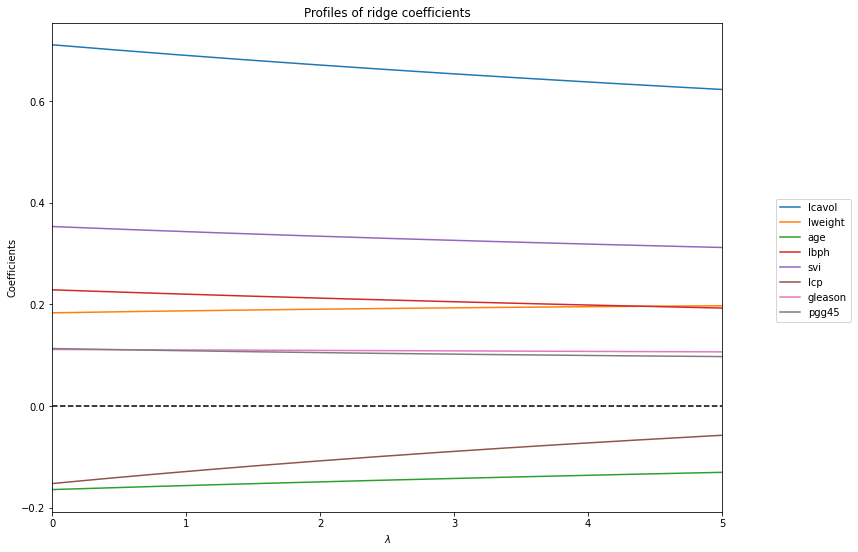

In [308]:
# -----------------Recreate Figure 3.8

fig = plt.figure(figsize=(12,9))
for index in range(1, x_train.shape[1]):
  plt.plot(lam_vec, ridge_graph_vec[:,index])
plt.plot((0,5), (0,0), 'k--')
plt.legend(x_train.columns[1:], loc='upper right', bbox_to_anchor=(1.2, 0.65))
plt.title('Profiles of ridge coefficients')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
plt.xlim([0,5])
plt.show()

In [309]:
# -----------------Lasso Regression

def compute_beta_lasso(lam_vec, x_train, y_train, x_val, y_val):
  # Initialize variables
  min_mse = float('inf')
  best_lam = None
  beta_lasso = []

  # Initialize coefficient array for plotting
  lasso_graph_vec = np.zeros((len(lam_vec), x_train.shape[1]))

  x_train_lasso = x_train.drop(['intercept'], axis=1)
  beta_zero = np.mean(y_train)

  # Determine the optimal lambda
  for index, lam in enumerate(lam_vec):
    clf = Lasso(alpha=lam)
    clf.fit(x_train_lasso, y_train)
    beta = np.concatenate(([beta_zero], clf.coef_), axis=0)
    # Save the coefficients for plotting
    lasso_graph_vec[index,:] = beta
    # Calulate MSE for current lambda
    mse_lasso = np.mean((y_val - np.dot(x_val, beta))**2)
    # If MSE less than min MSE: update min MSE and best lambda
    if mse_lasso < min_mse:
      min_mse = mse_lasso
      best_lam = lam
      beta_lasso = beta
    
  return beta_lasso, lasso_graph_vec, best_lam

# Initialize lambda array
lam_vec = np.linspace(1e-10,0.5,num=1000)

# Compute optimal coefficients
beta_lasso, lasso_graph_vec, best_lam = compute_beta_lasso(lam_vec, x_train, y_train, x_val, y_val)

# Calculate MSE with the test data
mse_lasso = np.mean((y_test - np.dot(x_test, beta_lasso))**2)
print("MSE using lasso regression on the test dataset: {}".format(mse_lasso))

MSE using lasso regression on the test dataset: 0.5227342879404895


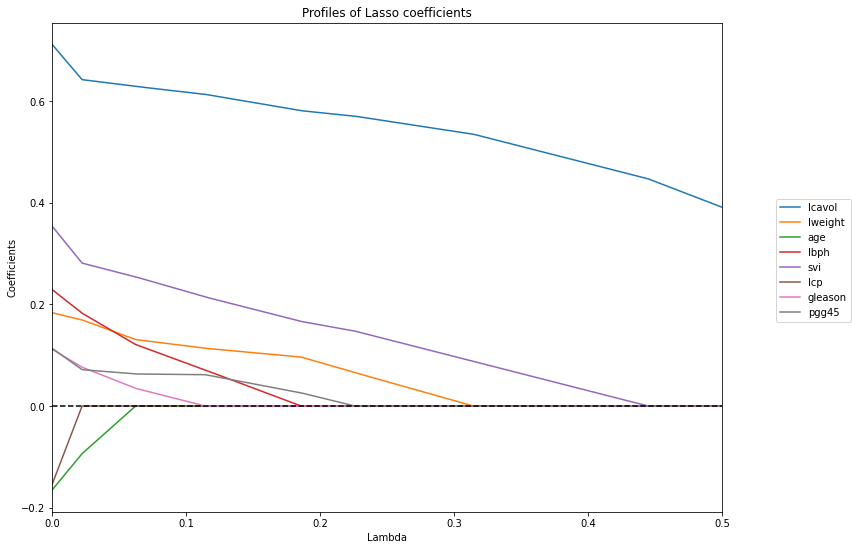

In [310]:
# -----------------Recreate Figure 3.10

fig = plt.figure(figsize=(12,9))
for index in range(1, x_train.shape[1]):
  plt.plot(lam_vec, lasso_graph_vec[:,index])
plt.plot((0,5), (0,0), 'k--')
plt.legend(x_train.columns[1:], loc='upper right', bbox_to_anchor=(1.2, 0.65))
plt.title('Profiles of Lasso coefficients')
plt.ylabel('Coefficients')
plt.xlabel('Lambda')
plt.xlim([0,0.5])
plt.show()

In [311]:
# -----------------Load custom data
df = pd.read_csv('https://github.com/jplulu/Frequentist-ML/raw/master/datasets/heart.csv')
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [312]:
# ----------------- Preprocess data

# Added ones column for intercept
ones_col = np.ones(len(df))
df.insert(0, "intercept", ones_col)

# Select random seed for data splitting
np.random.seed(42442)

# Separate training, validation, and testing data
df_train, df_val, df_test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

# Separate training inputs and outputs
x_train = df_train.drop(['target'], axis=1)
y_train = df_train['target']

# Separate validation inputs and outputs
x_val = df_val.drop(['target'], axis=1)
y_val = df_val['target']

# Separate testing inputs and outputs
x_test = df_test.drop(['target'], axis=1)
y_test = df_test['target']

# Standardizing predictors to zero mean unit variance
x_train = (x_train - x_train.mean()) / x_train.std()
x_train.intercept = np.ones(len(x_train))
x_val = (x_val - x_val.mean()) / x_val.std()
x_val.intercept = np.ones(len(x_val))
x_test = (x_test - x_test.mean()) / x_test.std()
x_test.intercept = np.ones(len(x_test))

In [313]:
# -----------------Linear Regression, No regularization

beta_noreg = compute_beta_noreg(x_train, y_train)

# Compute MSE on the training dataset
mse_noreg = np.mean((y_train - np.dot(x_train, beta_noreg))**2)
print("Mean squared error on the train dataset: {}".format(mse_noreg))

# Compute MSE on the test dataset
mse_noreg = np.mean((y_test - np.dot(x_test, beta_noreg))**2)
print("Mean squared error on the test dataset: {}".format(mse_noreg))

Mean squared error on the train dataset: 0.11352089574507318
Mean squared error on the test dataset: 0.17821137284451083


In [314]:
# -----------------Recreate Tables 3.1 and 3.2

# Compute and display correlation matrix
corr_matrix = df.drop(['intercept','target'], axis=1).corr()
display(corr_matrix)

# Compute and display linear model fit table
x_inv_diag = np.diagonal(np.linalg.inv(np.dot(x_train.transpose(), x_train)))
# Equation (3.12)
std_err = np.dot(beta_noreg.std(), np.sqrt(x_inv_diag))
z_score = beta_noreg / std_err
zipped_list =  list(zip(list(x_train.columns), beta_noreg, std_err, z_score))
model_fit_table = pd.DataFrame(zipped_list, columns = ['Term' , 'Coefficient', 'Std. Error', 'Z Score'])
display(model_fit_table)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736
trestbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981
thalach,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439
exang,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244


,Term,Coefficient,Std. Error,Z Score
0,intercept,0.557851,0.010379,53.748150
1,age,-0.012985,0.012525,-1.036736
2,sex,-0.089948,0.011289,-7.967494
3,cp,0.096581,0.011784,8.196110
4,trestbps,-0.048058,0.011211,-4.286578
5,chol,0.002817,0.011430,0.246416
6,fbs,0.011308,0.010917,1.035800
7,restecg,0.035068,0.011078,3.165453
8,thalach,0.041585,0.013265,3.135004
9,exang,-0.084683,0.012243,-6.916950


In [315]:
# -----------------Ridge Regression

# Initialize lambda array
lam_vec = np.linspace(0,10,num=1000)

# Compute optimal coefficients
beta_ridge, ridge_graph_vec, best_lam = compute_beta_ridge(lam_vec, x_train, y_train, x_val, y_val)

# Compute MSE on the training dataset
mse_ridge = np.mean((y_train - np.dot(x_train, beta_ridge))**2)
print("Mean squared error on the train dataset: {}".format(mse_ridge))

# Calculate MSE with the test data
mse_ridge = np.mean((y_test - np.dot(x_test, beta_ridge))**2)
print("MSE using ridge regression on the test dataset: {}".format(mse_ridge))

Mean squared error on the train dataset: 0.11404590006625
MSE using ridge regression on the test dataset: 0.17152600098537238


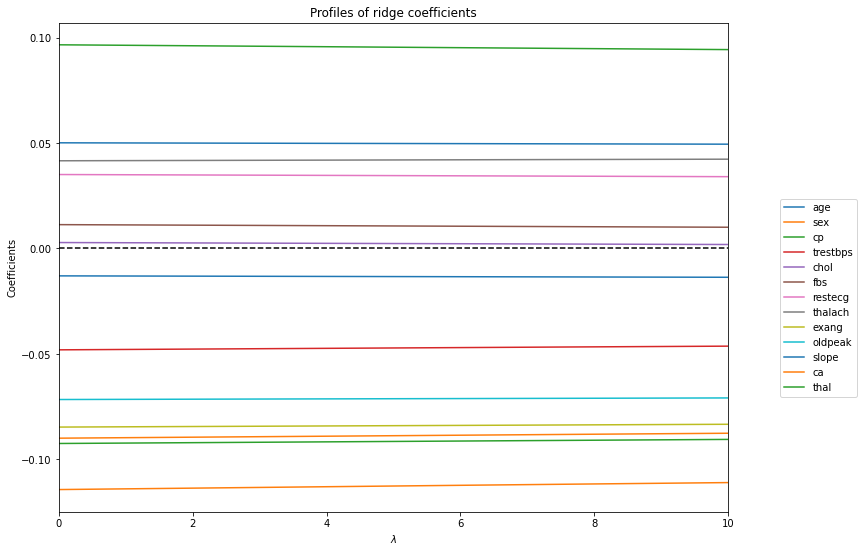

In [316]:
# -----------------Recreate Figure 3.8

fig = plt.figure(figsize=(12,9))
for index in range(1, x_train.shape[1]):
  plt.plot(lam_vec, ridge_graph_vec[:,index])
plt.plot((0,10), (0,0), 'k--')
plt.legend(x_train.columns[1:], loc='upper right', bbox_to_anchor=(1.2, 0.65))
plt.title('Profiles of ridge coefficients')
plt.ylabel('Coefficients')
plt.xlabel('$\lambda$')
plt.xlim([0,10])
plt.show()

In [319]:
# -----------------Lasso Regression

# Initialize lambda array
lam_vec = np.linspace(1e-10,0.5,num=1000)

# Compute optimal coefficients
beta_lasso, lasso_graph_vec, best_lam = compute_beta_lasso(lam_vec, x_train, y_train, x_val, y_val)

# Compute MSE on the training dataset
mse_lasso = np.mean((y_train - np.dot(x_train, beta_lasso))**2)
print("Mean squared error on the train dataset: {}".format(mse_lasso))

# Calculate MSE with the test data
mse_lasso = np.mean((y_test - np.dot(x_test, beta_lasso))**2)
print("MSE using lasso regression on the test dataset: {}".format(mse_lasso))

# Find included and excluded features
lasso_features = [i for i in x_train.columns[beta_lasso != 0]]
lasso_excluded_features = list(set(x_train.columns.values)-set(lasso_features))
print("Features included by lasso method:", lasso_features)
print("Features excluded by lasso method:", lasso_excluded_features)

Mean squared error on the train dataset: 0.1140500759980317
MSE using lasso regression on the test dataset: 0.17700581675232294
Features included by lasso method: ['intercept', 'age', 'sex', 'cp', 'trestbps', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Features excluded by lasso method: ['fbs', 'chol']


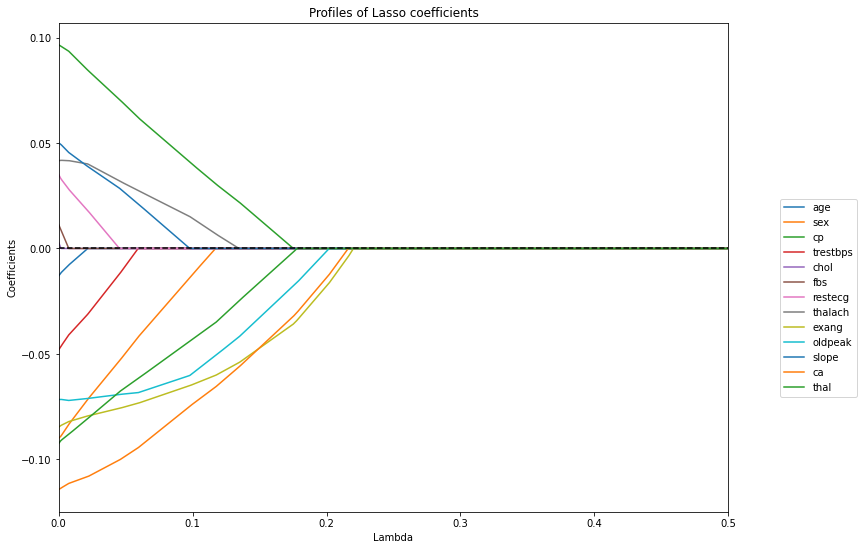

In [318]:
# -----------------Recreate Figure 3.10

fig = plt.figure(figsize=(12,9))
for index in range(1, x_train.shape[1]):
  plt.plot(lam_vec, lasso_graph_vec[:,index])
plt.plot((0,0.5), (0,0), 'k--')
plt.legend(x_train.columns[1:], loc='upper right', bbox_to_anchor=(1.2, 0.65))
plt.title('Profiles of Lasso coefficients')
plt.ylabel('Coefficients')
plt.xlabel('Lambda')
plt.xlim([0,0.5])
plt.show()